In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)


#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

In [2]:
data = BinaryIV.generate_data_rolling_ate(N_simulations=1)


In [3]:
sim = data.iloc[0]
df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
ZaffalonBounds.run_experiment_binaryIV_ATE(df)

JVM started with classpath: ['d:\\TUM Workspace\\Thesis Workspace\\causal-bounds\\simulation_engine\\algorithms\\zaffalon\\binaryIV\\zaffalon.jar', 'd:\\TUM Workspace\\Thesis Workspace\\causal-bounds\\simulation_engine\\algorithms\\zaffalon\\credici.jar']


java.lang.NoClassDefFoundError: java.lang.NoClassDefFoundError: binaryIV_py/BinaryIVAteSimulationTask (wrong name: binaryIV/BinaryIVAteSimulationTask)

In [12]:
binaryIV = BinaryIV('IV Dag', data)

# binaryIV.bound_ate_2SLS()
binaryIV.bound_ate_causaloptim()
# binaryIV.bound_ate_autobound()
# binaryIV.bound_ate_entropy(entr=0.80)
# binaryIV.data

Algorithm: causaloptim
  Fail Rate: 1.00%
  Invalid Rate: 2.02%
  Net Bound Width: 0.7103161480702582
Algorithm: 2SLS not found in dataframe columns.
Algorithm: autobound not found in dataframe columns.
Algorithm: entropybounds not found in dataframe columns.


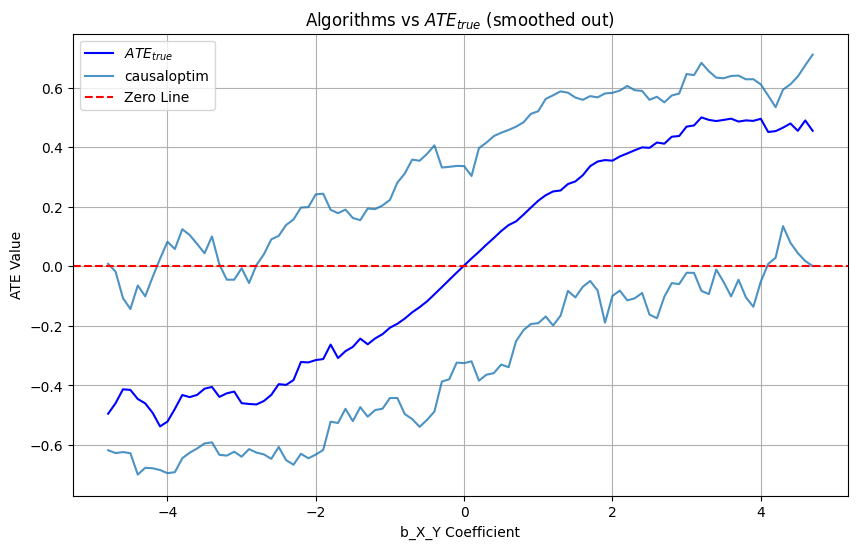

In [13]:
binaryIV.data
algorithms = ['causaloptim', '2SLS', 'autobound', 'entropybounds']
PlottingUtil.print_bound_statistics(binaryIV.data, algorithms)
PlottingUtil.plot_smoothed_ate_vs_bounds(binaryIV.data, algorithms, 5)


In [9]:
invalids = binaryIV.data[binaryIV.data['causaloptim_bound_valid'] == False]
invalIV = BinaryIV('IV Dag', invalids)
invalIV.bound_ate_causaloptim()
invalIV.data

caputured: R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!


Invalid Bounds detected
caputured: 
caputured: 


,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,causaloptim_bound_lower,causaloptim_bound_upper,causaloptim_bound_valid,causaloptim_bound_width,causaloptim_bound_failed
3,944243,0,0,2.264300,-0.893513,-4.7,-0.207546,-0.448266,0.007581,0.455847,0.866774,0.819945,"[1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.705637,0.599739,0.849943,0.517753,-0.344369,-0.348804,False,-0.004435,False
49,877939,0,0,-1.917451,1.823300,-0.1,-1.612648,-0.013956,0.168286,0.182243,0.949875,0.809191,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.697269,0.277840,0.998049,0.614823,-0.157216,-0.107379,False,0.049838,False
90,220567,0,0,-1.028126,-2.033834,4.0,0.054696,0.472237,0.982737,0.510499,0.792267,0.222949,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...",0.737642,0.781481,0.653109,0.963497,-0.282440,0.451923,False,0.734363,False
